# Sleep health and lifestyle

https://www.kaggle.com/datasets/imaginativecoder/sleep-health-data-sampled

## Dataset Columns:

- **Person ID:** An identifier for each individual.
- **Gender:** The gender of the person (Male/Female).
- **Age:** The age of the person in years.
- **Occupation:** The occupation or profession of the person.
- **Sleep Duration (hours):** The number of hours the person sleeps per day.
- **Quality of Sleep (scale: 1-10):** A subjective rating of the quality of sleep, ranging from 1 to 10.
- **Physical Activity Level (minutes/day):** The number of minutes the person engages in physical activity daily.
- **Stress Level (scale: 1-10):** A subjective rating of the stress level experienced by the person, ranging from 1 to 10.
- **BMI Category:** The BMI category of the person (e.g., Underweight, Normal, Overweight).
- **Blood Pressure (systolic/diastolic):** The blood pressure measurement of the person, indicated as systolic pressure over diastolic pressure.
- **Heart Rate (bpm):** The resting heart rate of the person in beats per minute. Daily Steps: The number of steps the person takes per day.
- **Sleep Disorder:** The presence or absence of a sleep disorder in the person (None, Insomnia, Sleep Apnea).

**Target** : sleep quality

In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Modeling & preprocessing import
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer,make_column_transformer,make_column_selector

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

# Model Tuning
from sklearn.model_selection import GridSearchCV

# For model evaluation (using Regression metrics)
from sklearn.metrics import mean_absolute_error,mean_squared_error, r2_score

path = '/content/Sleep_Data_Sampled.csv' # chemin pour trouver le dataset

# Preparer le dataset

In [75]:
df= pd.read_csv(path) # pour utiliser notre dataset avec pandas

## Clean

On visualise notre dataset

In [73]:
# Check for duplicates and missing values
print('DataSet head:\n', df.head())
print('\n')
print('DataSet info:\n', df.info())
print('\n')
print('Missing data:\n', df.isna().sum())
print('\n')
print('Duplicates:', df.duplicated().sum())
print('\n')
print("Columns's type:\n", df.dtypes)
print('\n')
print("Unique value in Person ID:",df['Person ID'].nunique())
print('\n')
print("BMI Category value :\n", df['BMI Category'].value_counts())
print('\n')
print("Sleep Disorder value :\n", df['Sleep Disorder'].value_counts())


DataSet head:
    Person ID Gender  Age         Occupation  Sleep Duration  Quality of Sleep  \
0          1   Male   35             Doctor            6.65                 7   
1          2   Male   42            Teacher            6.90                 8   
2          3   Male   34  Software Engineer            6.95                 7   
3          4   Male   32             Doctor            6.90                 6   
4          5   Male   37             Lawyer            6.85                 7   

   Physical Activity Level  Stress Level   BMI Category Blood Pressure  \
0                       50             7  Normal Weight         120/80   
1                       52             4         Normal         135/90   
2                       66             6     Overweight         126/83   
3                       52             7         Normal         120/80   
4                       60             6         Normal         125/80   

   Heart Rate  Daily Steps Sleep Disorder  
0        

## Pipeline



In [76]:
split_data = df['Blood Pressure'].str.split('/', expand=True)
# On assigne les résultats aux nouvelles colonnes en convertissant en numérique
df['Systolic'] = pd.to_numeric(split_data[0], errors='coerce')
df['Diastolic'] = pd.to_numeric(split_data[1], errors='coerce')
# On supprime l'ancienne colonne qui n'est plus utile
df.drop('Blood Pressure', axis=1, inplace=True)

df.set_index('Person ID', inplace=True)

Gender type: int64


/tmp/ipython-input-3028251308.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Gender']= df['Gender'].replace("Male", 1)


'df[\'BMI Category\']= df[\'BMI Category\'].replace("Underweight", 1)\ndf[\'BMI Category\']= df[\'BMI Category\'].replace("Normal", 2)\ndf[\'BMI Category\']= df[\'BMI Category\'].replace("Normal Weight", 3)\ndf[\'BMI Category\']= df[\'BMI Category\'].replace("Overweight", 4)\ndf[\'BMI Category\']= df[\'BMI Category\'].replace("Obese", 5)\n\nprint(\'BMI Category type:\',df[\'BMI Category\'].dtypes)\ndf[\'BMI Category\'].hist() # pour voir un histogramme qui montre combien de fois les valeurs sont répétées'

In [77]:
df.head()

,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Heart Rate,Daily Steps,Sleep Disorder,Systolic,Diastolic
Person ID,,,,,,,,,,,,,
1,1,35,Doctor,6.65,7,50,7,Normal Weight,71,7100,Healthy,120,80
2,1,42,Teacher,6.90,8,52,4,Normal,66,7000,Healthy,135,90
3,1,34,Software Engineer,6.95,7,66,6,Overweight,74,6100,Healthy,126,83
4,1,32,Doctor,6.90,6,52,7,Normal,71,6500,Healthy,120,80
5,1,37,Lawyer,6.85,7,60,6,Normal,71,6500,Healthy,125,80


In [91]:
## Define X and y
target = 'Quality of Sleep'

X = df.drop(columns=target).copy()
y = df[target].copy()

# Perfoming a train-test-split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

# Defining a list of features for both the categorical and the numerical columns

cat_feature = make_column_selector(dtype_include='object')   # Creating a categorical data selector
num_feature = make_column_selector(dtype_include='number')   # Creating a numeric data selector

# Instantiating the Transformers

impute_cat = SimpleImputer(strategy='most_frequent') #better to keep the ffil but for simplicity reasons I will keep this one
impute_num = SimpleImputer(strategy='median') # we can be more sophisticated and make a mean imputation for widht like we did earlier, but I'll keep it simple for now
ohe_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')   # It is a numinal column with no order to it => So I used the One-hot encoding
scaler = StandardScaler()

# Making pipelines for each category

pip_cat = make_pipeline(impute_cat, ohe_encoder)
pip_num = make_pipeline(impute_num, scaler)

# Defining a tuple for each pathway

categorical_tup = ('Categorical', pip_cat, cat_feature)
numerical_tup = ('Numerical', pip_num, num_feature)

# Instantiating the ColumnTransformer

col_transformer = ColumnTransformer([numerical_tup, categorical_tup], verbose_feature_names_out=False)
col_transformer


ColumnTransformer(transformers=[('Numerical',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7a12bc0ac2f0>),
                                ('Categorical',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7a12c770c320>)],
                  verbose_feature_names_out=False)

## Regarde corélation entre features and target

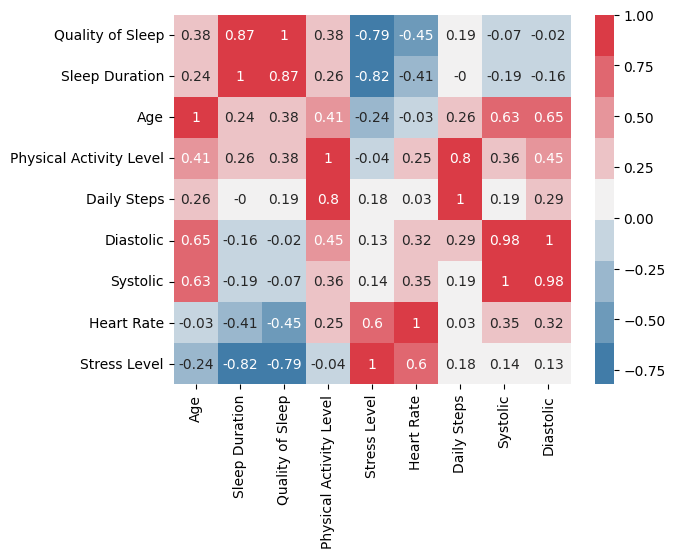

In [108]:
corr = df.corr(numeric_only=True).sort_values(by=target, ascending=False).round(2)

ax = sns.heatmap(corr,
            cmap = sns.diverging_palette(240, 10, n=9), annot = True);

In [106]:
filt_abs_corr = corr[target].abs().sort_values(ascending=False)
filt_abs_corr

,Quality of Sleep
Quality of Sleep,1.00
Sleep Duration,0.87
Stress Level,0.79
Heart Rate,0.45
Age,0.38
Physical Activity Level,0.38
Daily Steps,0.19
Systolic,0.07
Diastolic,0.02


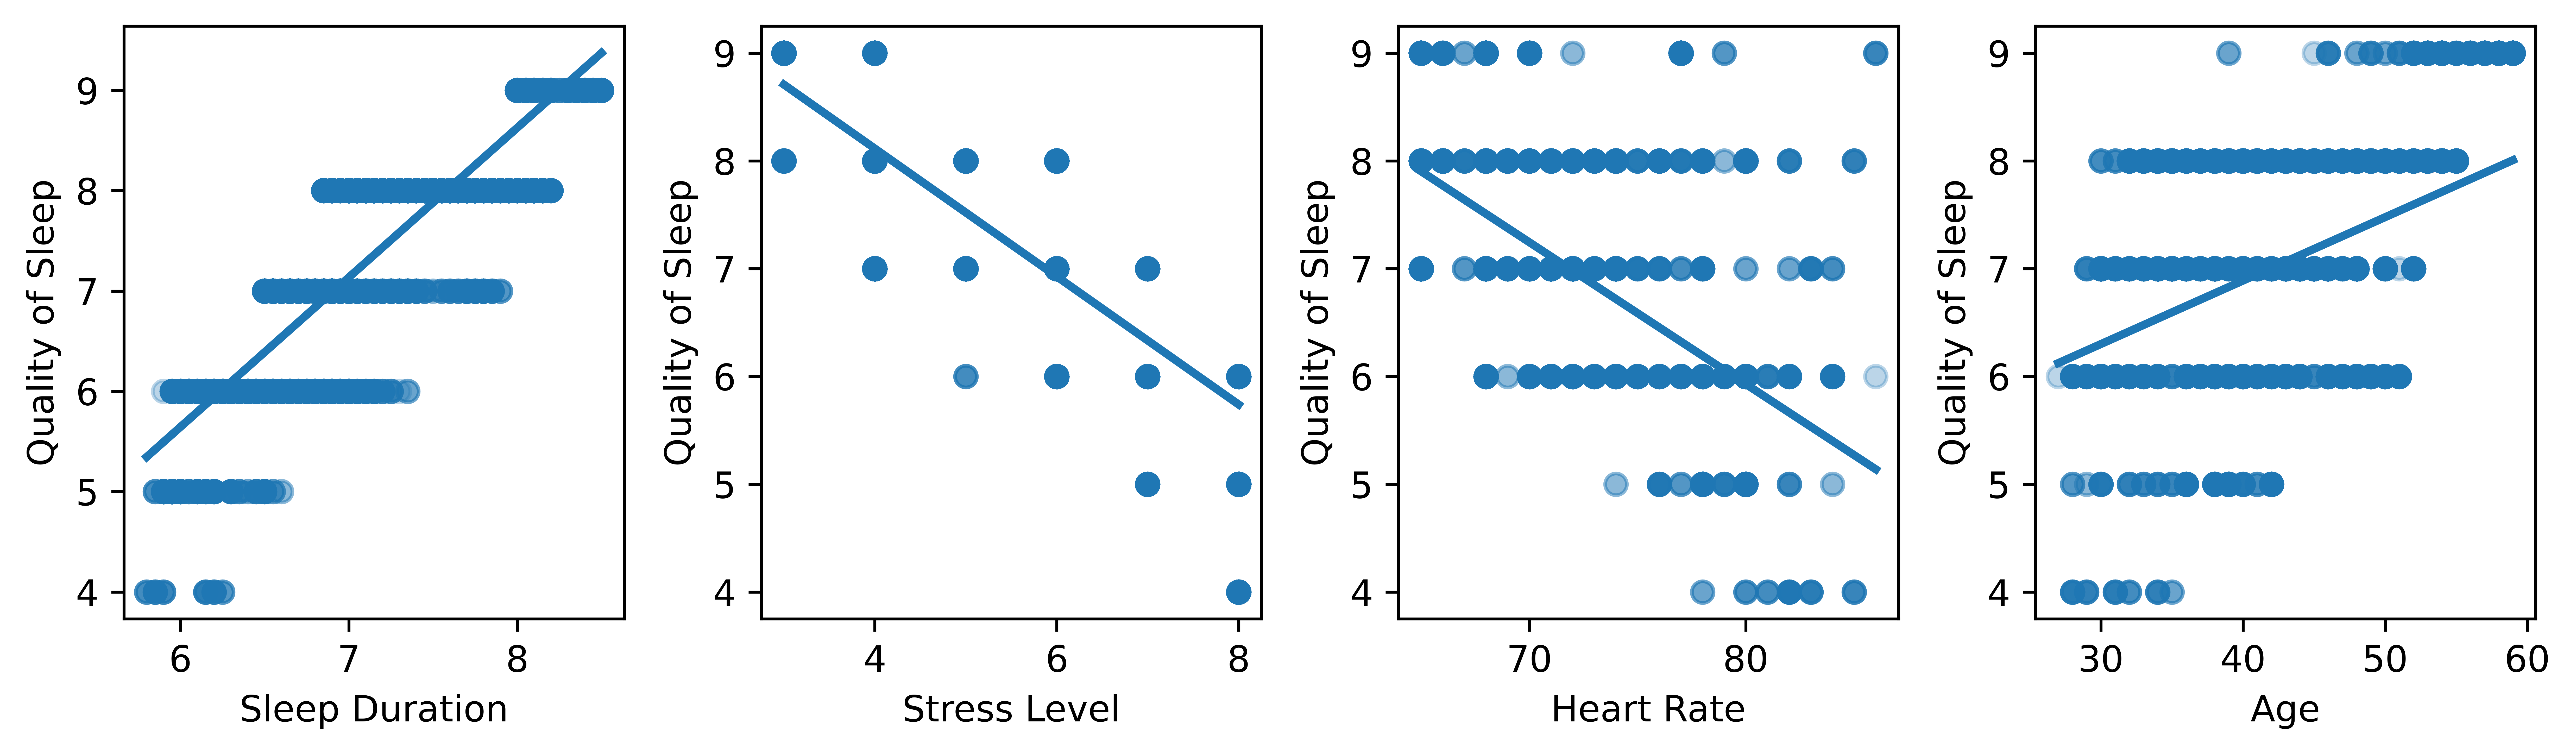

In [125]:
fig, axes = plt.subplots(nrows = 1,ncols = 4,figsize = (10,3), dpi=1000)
sns.regplot(x='Sleep Duration', y='Quality of Sleep', data=df, ci=None, ax = axes[0], scatter_kws={'alpha':0.3});
sns.regplot(x='Stress Level', y='Quality of Sleep', data=df, ci=None, ax = axes[1], scatter_kws={'alpha':0.3});
sns.regplot(x='Heart Rate', y='Quality of Sleep', data=df, ci=None, ax = axes[2], scatter_kws={'alpha':0.3});
sns.regplot(x='Age', y='Quality of Sleep', data=df, ci=None, ax = axes[3], scatter_kws={'alpha':0.3});
fig.tight_layout()

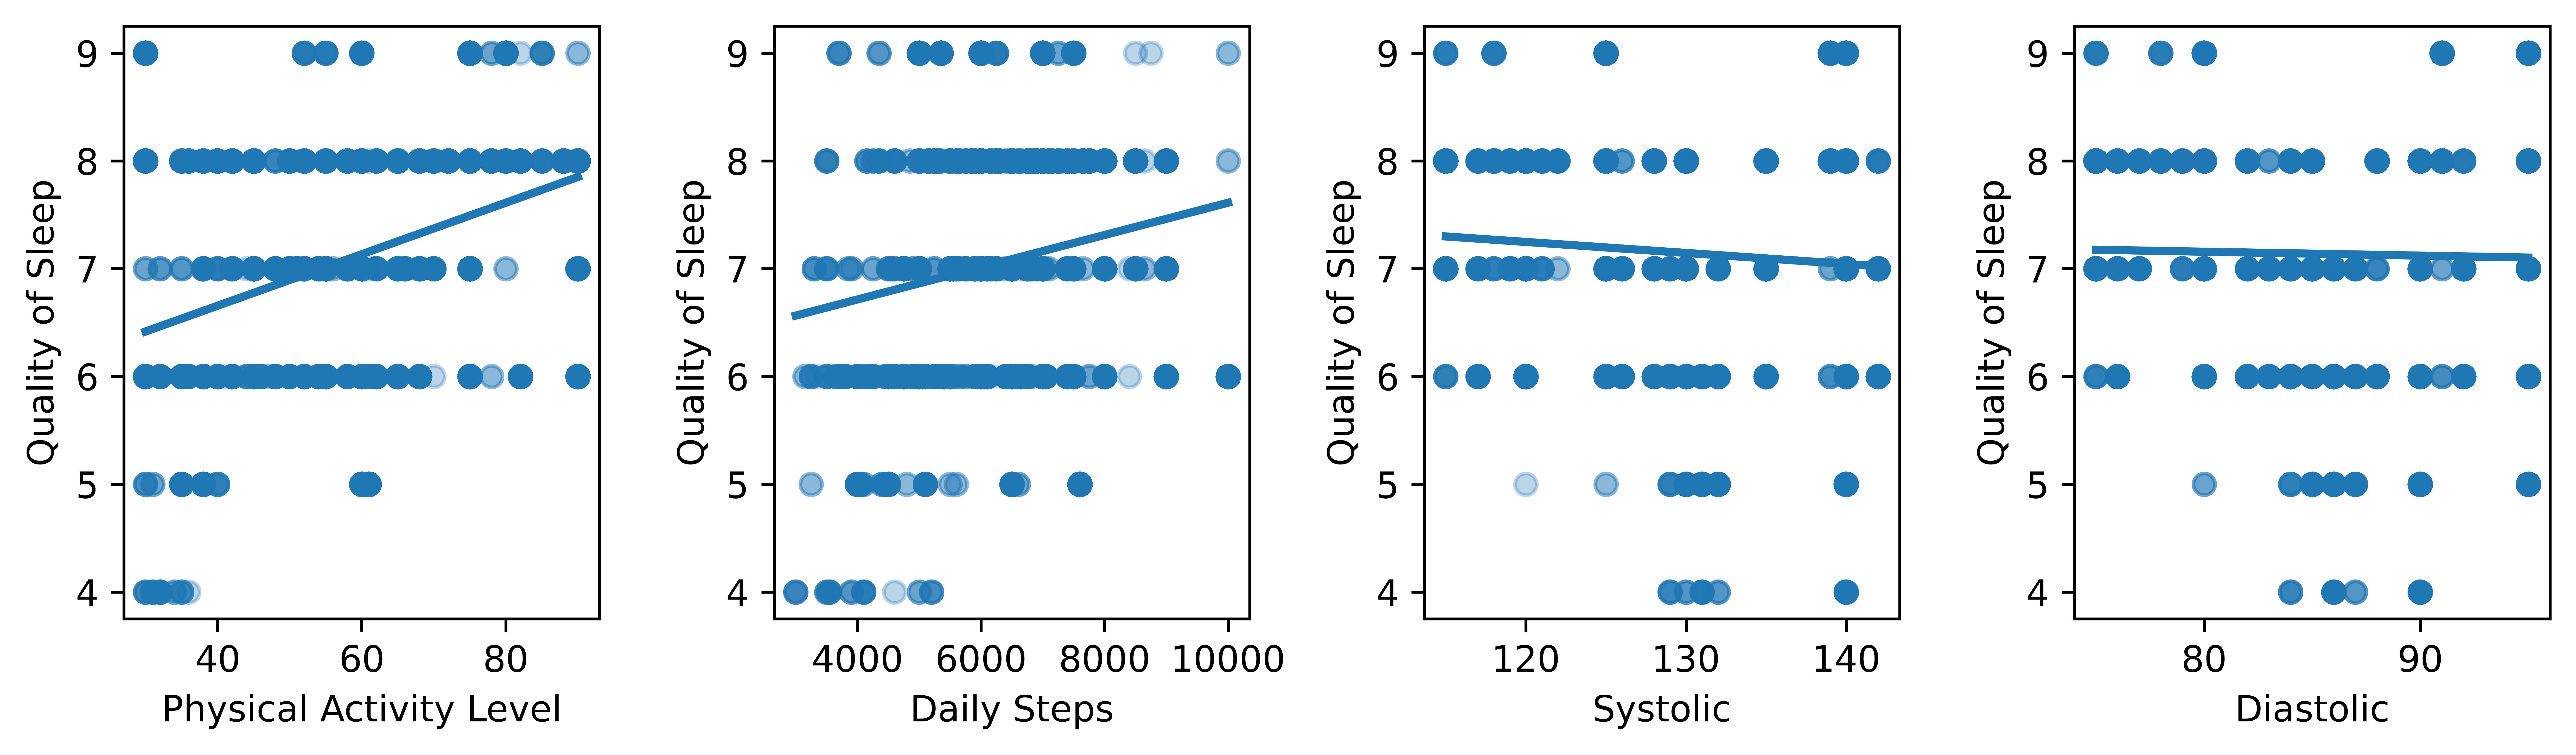

In [124]:
fig, axes = plt.subplots(nrows = 1,ncols = 4,figsize = (10,3), dpi=1000)
sns.regplot(x='Physical Activity Level', y='Quality of Sleep', data=df, ci=None, ax = axes[0], scatter_kws={'alpha':0.3});
sns.regplot(x='Daily Steps', y='Quality of Sleep', data=df, ci=None, ax = axes[1], scatter_kws={'alpha':0.3});
sns.regplot(x='Systolic', y='Quality of Sleep', data=df, ci=None, ax = axes[2], scatter_kws={'alpha':0.3});
sns.regplot(x='Diastolic', y='Quality of Sleep', data=df, ci=None, ax = axes[3], scatter_kws={'alpha':0.3});
fig.tight_layout()

## Observation
On voit que les 3 premieres colonnes sont quasi linéaire, mais cela n'est pas du tout le cas pour les autres colonnes.

# Utiliser le dataSet

## Modèle 1 : Linear Regression

In [117]:
# Regression model

# Instantiate a linear regression model
linreg = LinearRegression()
# Combine the preprocessing ColumnTransformer and the linear regression model in a Pipeline
model_pipe_LR = make_pipeline(col_transformer, linreg)

# Fit the modeling pipeline on the training data
model_pipe_LR.fit(X_train, y_train)

# Use the model to make predictions for training and testing data to evaluate later on

y_pred_train = model_pipe_LR.predict(X_train)

y_pred_test = model_pipe_LR.predict(X_test)


## Evaluation Modèle 1

In [118]:
#evaluation functions

def eval_model(true, pred):
  MAE = mean_absolute_error(true, pred)
  MSE = mean_squared_error(true, pred)
  RMSE = np.sqrt(MSE)
  r2 = r2_score(true, pred)

  print(f'MAE: {MAE:,.2f} \n MSE: {MSE:,.2f} \n RMSE: {RMSE:,.2f} \n R2: {r2:,.2f} ')

print('Train Evaluation Modèle 1, Linear Regression''\n')
eval_model(y_train, y_pred_train)
print('\n')

print('Test Evaluation''\n')
eval_model(y_test, y_pred_test)

Train Evaluation Modèle 1, Linear Regression

MAE: 0.32 
 MSE: 0.14 
 RMSE: 0.38 
 R2: 0.87 


Test Evaluation

MAE: 0.32 
 MSE: 0.15 
 RMSE: 0.39 
 R2: 0.86 


## Modèle 2 : Random Forest

In [119]:
# Random forest

R_F_default = RandomForestRegressor(random_state = 42)

# Combine the preprocessing ColumnTransformer and the Random Forst model in a Pipeline
model_pipe_RF = make_pipeline(col_transformer, R_F_default)

# Fit the modeling pipeline on the training data
model_pipe_RF.fit(X_train, y_train)

train_preds = model_pipe_RF.predict(X_train)
test_preds = model_pipe_RF.predict(X_test)

train_rf_score = r2_score(y_train, train_preds)
test_rf_score = r2_score(y_test, test_preds)

print(f'- maximum depth of the random forest tree: {max([estimator.get_depth() for estimator in R_F_default.estimators_])}')
print(f'- the number of trees in the foreste? {R_F_default.n_estimators}' '\n')

# Use the model to make predictions for training and testing data to evaluate later on

y_pred_train = model_pipe_LR.predict(X_train)

y_pred_test = model_pipe_LR.predict(X_test)

- maximum depth of the random forest tree: 22
- the number of trees in the foreste? 100



## Evalution Modèle 2

In [120]:
print('Train Evaluation Modèle 2, Random Forest''\n')
eval_model(y_train, y_pred_train)
print('\n')

print('Test Evaluation''\n')
eval_model(y_test, y_pred_test)

Train Evaluation Modèle 2, Random Forest

MAE: 0.32 
 MSE: 0.14 
 RMSE: 0.38 
 R2: 0.87 


Test Evaluation

MAE: 0.32 
 MSE: 0.15 
 RMSE: 0.39 
 R2: 0.86 


## Obseravtion :
On obtient des valeurs similaire ce qui pourrait signifier que les valeurs non corrélé sont de véritable bruit.
Les valeurs considéré comme du bruit par le modèle linéaire sont de vrai bruit.